# Importing Libraries

In [1]:
from tensorflow.keras.models import model_from_json
from fer_model import get_fer_model
import tensorflow as tf
import tempfile 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.optimizers import Adam

import os
import zipfile

import tensorflow_model_optimization as tfmot
import pickle

In [4]:
from datetime import date
TIMESTAMP = str(date.today())

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Loading the CK+ Dataset

In [3]:
from data import load_ckplus
train_generator = load_ckplus("train")
test_generator = load_ckplus("test")

Found 924 images belonging to 8 classes.
Found 384 images belonging to 8 classes.


# Load Baseline Model

In [6]:
model = get_fer_model()
model.load_weights("weights/model_weights_2021-04-20.h5")

In [7]:
from evaluation import get_metrics
print("Baseline model performance:")
get_metrics(model, test_generator)

Baseline model performance:


{'size': 16512520,
 'acc': 0.7109375,
 'f_acc': 0.7,
 'm_acc': 0.7291666666666666,
 'f_acc_breakdown': [0.6666666666666666,
  0.5151515151515151,
  1.0,
  0.7083333333333334,
  0.5714285714285714,
  0.8666666666666667,
  0.26666666666666666,
  0.8888888888888888],
 'f_acc_balanced': 0.6854752886002886,
 'm_acc_breakdown': [0.5277777777777778,
  0.25,
  1.0,
  1.0,
  0.0,
  0.8333333333333334,
  0.3333333333333333,
  1.0],
 'm_acc_balanced': 0.6180555555555556}

# Apply Weight Clustering

In [8]:
N_CLUSTERS = 16

In [9]:
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': N_CLUSTERS,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = Adam(lr=0.0005)

clustered_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

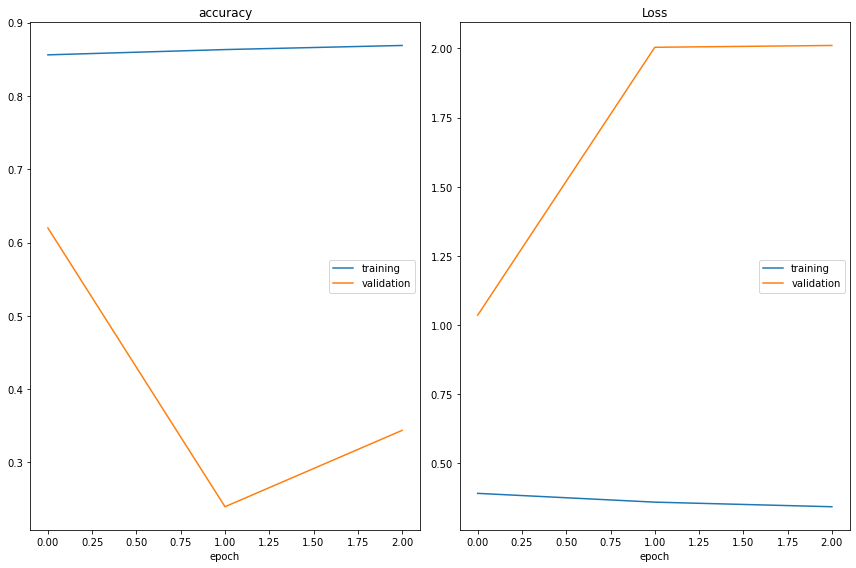

accuracy
	training         	 (min:    0.856, max:    0.869, cur:    0.869)
	validation       	 (min:    0.240, max:    0.620, cur:    0.344)
Loss
	training         	 (min:    0.343, max:    0.392, cur:    0.343)
	validation       	 (min:    1.036, max:    2.011, cur:    2.011)

Epoch 00003: val_accuracy did not improve from 0.61979
28/28 [==============================] - 42s 2s/step - loss: 0.3433 - accuracy: 0.8688 - val_loss: 2.0109 - val_accuracy: 0.3438


In [11]:
# Fine-Tuning 
epochs = 3
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = test_generator.n//test_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint_name = "weights/clustered_model_c%d_%s.h5" % (N_CLUSTERS, TIMESTAMP)
checkpoint = ModelCheckpoint(checkpoint_name, 
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True, 
                             mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), 
             checkpoint, 
             reduce_lr, 
             ]

clustered_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = test_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

# Only use the best weights 
clustered_model.load_weights(checkpoint_name)

In [12]:
clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)

# Evaluate Clustered Model

In [13]:
print("Model performance after weight clustering:")
metrics = get_metrics(clustered_model, test_generator)
metrics

Model performance after weight clustering:


{'size': 2957251,
 'acc': 0.6197916666666666,
 'f_acc': 0.5958333333333333,
 'm_acc': 0.6597222222222222,
 'f_acc_breakdown': [0.3333333333333333,
  0.6666666666666666,
  0.8333333333333334,
  0.625,
  0.23809523809523808,
  0.8666666666666667,
  0.3333333333333333,
  0.8888888888888888],
 'f_acc_balanced': 0.5981646825396826,
 'm_acc_breakdown': [0.1111111111111111,
  0.4166666666666667,
  1.0,
  1.0,
  0.0,
  0.9583333333333334,
  0.3333333333333333,
  1.0],
 'm_acc_balanced': 0.6024305555555556}

### Store results

In [14]:
with open("logs/clustered_model_metrics_c%d_%s.h5" % (N_CLUSTERS, TIMESTAMP), 
          'wb') as clustered_model_metrics_file:
        pickle.dump(metrics, clustered_model_metrics_file)

# Apply Quantisation to Clustered Model 

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(clustered_model)
# This optimisation includes the quantisation 
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_clustered_tflite_model = converter.convert()

# Evaluate Quantised and Clustered Model

In [16]:
from evaluation import get_metrics_quantised
metrics = get_metrics_quantised(quantized_and_clustered_tflite_model, test_generator)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.


In [18]:
print("Clustered and quantised model performance:")
metrics

Clustered and quantised model performance:


{'size': 2604424,
 'acc': 0.6041666666666666,
 'f_acc': 0.5833333333333334,
 'm_acc': 0.6388888888888888,
 'f_acc_breakdown': [0.3333333333333333,
  0.6666666666666666,
  0.8333333333333334,
  0.625,
  0.19047619047619047,
  0.8666666666666667,
  0.26666666666666666,
  0.8666666666666667],
 'f_acc_balanced': 0.5811011904761905,
 'm_acc_breakdown': [0.08333333333333333,
  0.4166666666666667,
  1.0,
  1.0,
  0.0,
  0.875,
  0.3333333333333333,
  1.0],
 'm_acc_balanced': 0.5885416666666667}

### Store results

In [19]:
with open("logs/clustered_and_quantised_model_metrics_c%d_%s.h5" % (N_CLUSTERS, TIMESTAMP), 
          'wb') as clustered_and_quantised_model_metrics_file:
        pickle.dump(metrics, clustered_and_quantised_model_metrics_file)